In [52]:
# Setup and imports
import os
import json
import random
import numpy as np
import rasterio
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pickle
from datetime import datetime

# Enable mixed precision for faster training
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print("GPU Available:", tf.config.list_physical_devices('GPU'))
print(f"Mixed precision policy: {policy.name}")
print(f"Compute dtype: {policy.compute_dtype}")
print(f"Variable dtype: {policy.variable_dtype}")

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mixed precision policy: mixed_float16
Compute dtype: float16
Variable dtype: float32


In [53]:
# Configuration (Kaggle paths preserved)
BASE_DIR = '/kaggle/input/ps3-train/PS3/'
MOCK_DIR = '/kaggle/input/mock-dataset/'

# Derived Paths 
LABELED_SAMPLES_DIR = os.path.join(BASE_DIR, 'Training dataset/PS03_1/Datasets/sample-set/sample-set/')
UNLABELED_TRAINING_DIR = os.path.join(BASE_DIR, 'Training dataset/PS03_2/development-set/')
MOCK_DATASET_DIR = os.path.join(MOCK_DIR, 'mock-dataset-tif/')

# Define all target classes (MUST match submission output names)
ALL_CLASSES = ["Playground", "Brick Kiln", "Metro Shed", "Pond-1", 
               "Pond-2", "Sheds", "Solar Panel", "STP"]

# Model and Training Hyperparameters
CHIP_SIZE = (64, 64)
NUM_CHANNELS = 4
EMBEDDING_DIM = 128
MARGIN = 0.5
P_CLASSES = 8
K_SAMPLES = 3  # Lowered from 4 to increase eligible classes
BATCH_SIZE = P_CLASSES * K_SAMPLES
EPOCHS = 150
WARMUP_EPOCHS = 5
LR_BASE = 1e-4
WEIGHT_DECAY = 1e-4

# Inference Hyperparameters 
STRIDE_COARSE = CHIP_SIZE[0] // 2
NMS_THRESHOLD = 0.3
NUM_EXEMPLARS = 5

# Output paths
OUTPUT_DIR = '/kaggle/working/'
STATS_PATH = os.path.join(OUTPUT_DIR, 'normalization_stats.json')
MODEL_PATH = os.path.join(OUTPUT_DIR, 'siamese_base_network.keras')
CALIBRATION_PATH = os.path.join(OUTPUT_DIR, 'calibration_params.pkl')
THRESHOLDS_PATH = os.path.join(OUTPUT_DIR, 'class_thresholds.json')

print(f"Base directory: {BASE_DIR}")
print(f"Training for {len(ALL_CLASSES)} classes")
print(f"Batch size: {BATCH_SIZE} (P={P_CLASSES}, K={K_SAMPLES})")
print(f"Configuration complete.")

Base directory: /kaggle/input/ps3-train/PS3/
Training for 8 classes
Batch size: 24 (P=8, K=3)
Configuration complete.


In [69]:
# Data loading with proper normalization and robust image resolution

def load_4_band_image_raw(image_path):
    """Loads a 4-band TIFF image in [B,G,R,NIR] order."""
    with rasterio.open(image_path, 'r') as f:
        img = np.stack([f.read(1), f.read(2), f.read(3), f.read(4)], axis=-1)
    return img.astype(np.float32)

def probe_radiometry(image_paths, num_samples=5):
    """Probe a few images to detect scaling."""
    print("Probing radiometry...")
    for i, path in enumerate(image_paths[:num_samples]):
        img = load_4_band_image_raw(path)
        print(f"  Image {i+1}: shape={img.shape}, min={img.min():.1f}, max={img.max():.1f}, mean={img.mean():.1f}")
    

def compute_normalization_stats(image_paths, scale_factor=None):
    """Compute per-band mean/std for z-score normalization."""
    print("Computing normalization stats...")
    all_pixels = []
    for path in tqdm(image_paths[:50], desc="Sampling images"):
        img = load_4_band_image_raw(path)
        if scale_factor:
            img = img / scale_factor
        all_pixels.append(img.reshape(-1, NUM_CHANNELS))
    
    all_pixels = np.concatenate(all_pixels, axis=0)
    mean = np.mean(all_pixels, axis=0)
    std = np.std(all_pixels, axis=0) + 1e-6
    
    print(f"  Per-band mean: {mean}")
    print(f"  Per-band std: {std}")
    return {'mean': mean.tolist(), 'std': std.tolist(), 'scale_factor': scale_factor}

def normalize_image(img, stats):
    """Apply scaling and z-score normalization."""
    if stats['scale_factor']:
        img = img / stats['scale_factor']
    mean = np.array(stats['mean'], dtype=np.float32)
    std = np.array(stats['std'], dtype=np.float32)
    return (img - mean) / std

def build_image_index(root_dir, exts=(".tif", ".tiff")):
    """Builds a mapping from basename (without extension) -> full image path."""
    index = {}
    dup_counts = {}
    for r, _, files in os.walk(root_dir):
        for f in files:
            lf = f.lower()
            if any(lf.endswith(ext) for ext in exts):
                base = os.path.splitext(f)[0]
                path = os.path.join(r, f)
                if base in index:
                    cur = index[base]
                    if cur.lower().endswith('.tiff') and lf.endswith('.tif'):
                        index[base] = path
                    dup_counts[base] = dup_counts.get(base, 0) + 1
                else:
                    index[base] = path
    if len(dup_counts) > 0:
        print(f"Image index: {len(index)} unique basenames, {len(dup_counts)} duplicates across folders")
    else:
        print(f"Image index: {len(index)} unique basenames, no duplicates")
    return index

def resolve_image_path_for_json(json_path, image_index):
    """Resolve the image path for a JSON by matching basename via index."""
    base = os.path.splitext(os.path.basename(json_path))[0]
    if base in image_index and os.path.exists(image_index[base]):
        return image_index[base]
    folder = os.path.dirname(json_path)
    tif_path = os.path.join(folder, base + '.tif')
    tiff_path = os.path.join(folder, base + '.tiff')
    if os.path.exists(tif_path):
        return tif_path
    if os.path.exists(tiff_path):
        return tiff_path
    return None

def get_chips_by_class_v2(base_dir, class_name, stats, image_index, padding_pct=0.15):
    """Extract chips with context padding and proper normalization.
    FIXED: Correct mapping from code class names to JSON class names.
    """
    chips = []
    
    # Map from code class names (ALL_CLASSES) to actual JSON class names
    code_to_json_class = {
        "Playground": "Play Ground",  # FIXED: JSON uses "Play Ground" with space!
        "Brick Kiln": "Brick Kiln",
        "Metro Shed": "Metro Shed",
        "Pond-1": "Pond-1",
        "Pond-2": "Pond-2",
        "Sheds": "Sheds",
        "Solar Panel": "Solar Panel",
        "STP": "STP"
    }
    
    json_class_name = code_to_json_class.get(class_name)
    if json_class_name is None:
        print(f"  WARNING: Unknown class '{class_name}' - skipping")
        return chips

    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.json'):
                json_path = os.path.join(root, file)
                image_path = resolve_image_path_for_json(json_path, image_index)
                if not image_path or not os.path.exists(image_path):
                    continue
                
                full_image = load_4_band_image_raw(image_path)
                full_image = normalize_image(full_image, stats)
                
                with open(json_path, 'r') as f:
                    data = json.load(f)
                    for feature in data['features']:
                        feature_class = feature['properties'].get('Class Name', '')
                        
                        if feature_class == json_class_name:
                            coords = np.array(feature['geometry']['coordinates'][0][0]).astype(int)
                            x_min, y_min = coords.min(axis=0)
                            x_max, y_max = coords.max(axis=0)
                            
                            w, h = x_max - x_min, y_max - y_min
                            pad_x = int(w * padding_pct)
                            pad_y = int(h * padding_pct)
                            x_min = max(0, x_min - pad_x)
                            y_min = max(0, y_min - pad_y)
                            x_max = min(full_image.shape[1], x_max + pad_x)
                            y_max = min(full_image.shape[0], y_max + pad_y)
                            
                            if x_max <= x_min or y_max <= y_min:
                                continue
                            chip = full_image[y_min:y_max, x_min:x_max]
                            if chip.size > 0:
                                chips.append(cv2.resize(chip, CHIP_SIZE, interpolation=cv2.INTER_LINEAR))
    return chips


def get_background_chips(unlabeled_dir, labeled_dir, stats, num_chips=500):
    """Sample random background chips from unlabeled images, excluding labeled regions."""
    print(f"Sampling {num_chips} background chips...")
    
    exclusion_masks = {}
    for root, _, files in os.walk(labeled_dir):
        for file in files:
            if file.endswith('.json'):
                json_path = os.path.join(root, file)
                image_name = file.replace('.json', '.tif')
                
                with open(json_path, 'r') as f:
                    data = json.load(f)
                    mask_regions = []
                    for feature in data['features']:
                        coords = np.array(feature['geometry']['coordinates'][0][0]).astype(int)
                        x_min, y_min = coords.min(axis=0)
                        x_max, y_max = coords.max(axis=0)
                        w, h = x_max - x_min, y_max - y_min
                        dilation = int(max(w, h) * 0.2)
                        mask_regions.append((
                            max(0, x_min - dilation),
                            max(0, y_min - dilation),
                            x_max + dilation,
                            y_max + dilation
                        ))
                    exclusion_masks[image_name] = mask_regions
    
    background_chips = []
    unlabeled_files = [f for f in os.listdir(unlabeled_dir) if f.endswith('.tif') or f.endswith('.tiff')]
    
    attempts = 0
    max_attempts = num_chips * 10
    
    while len(background_chips) < num_chips and attempts < max_attempts:
        attempts += 1
        img_file = random.choice(unlabeled_files)
        img_path = os.path.join(unlabeled_dir, img_file)
        
        img = load_4_band_image_raw(img_path)
        img = normalize_image(img, stats)
        h, w = img.shape[:2]
        
        if h < CHIP_SIZE[0] or w < CHIP_SIZE[1]:
            continue
        
        y = random.randint(0, h - CHIP_SIZE[0])
        x = random.randint(0, w - CHIP_SIZE[1])
        
        img_key = os.path.splitext(img_file)[0] + '.tif'
        if img_key in exclusion_masks:
            overlap = False
            for ex_x_min, ex_y_min, ex_x_max, ex_y_max in exclusion_masks[img_key]:
                if not (x + CHIP_SIZE[1] < ex_x_min or x > ex_x_max or
                        y + CHIP_SIZE[0] < ex_y_min or y > ex_y_max):
                    overlap = True
                    break
            if overlap:
                continue
        
        chip = img[y:y+CHIP_SIZE[0], x:x+CHIP_SIZE[1]]
        background_chips.append(chip)
    
    print(f"  Sampled {len(background_chips)} background chips")
    return background_chips

print("Data loading functions defined with robust image resolution and background sampling.")

Data loading functions defined with robust image resolution and background sampling.


In [55]:
# Radiometry probing and normalization stats computation
# Collect all training image paths
training_image_paths = []
for root, _, files in os.walk(UNLABELED_TRAINING_DIR):
    for file in files:
        if file.endswith('.tif'):
            training_image_paths.append(os.path.join(root, file))

print(f"Found {len(training_image_paths)} training images.")

# Probe radiometry
probe_radiometry(training_image_paths, num_samples=5)

# Decide scale factor based on probe (if max > 1000, assume scaled reflectance)
sample_img = load_4_band_image_raw(training_image_paths[0])
if sample_img.max() > 1000:
    SCALE_FACTOR = 10000.0
    print(f"\nDetected scaled reflectance. Using scale factor: {SCALE_FACTOR}")
else:
    SCALE_FACTOR = None
    print("\nNo scaling detected. Using raw values.")

# Compute and save normalization stats
if os.path.exists(STATS_PATH):
    print(f"\nLoading existing normalization stats from {STATS_PATH}")
    with open(STATS_PATH, 'r') as f:
        norm_stats = json.load(f)
else:
    norm_stats = compute_normalization_stats(training_image_paths, scale_factor=SCALE_FACTOR)
    with open(STATS_PATH, 'w') as f:
        json.dump(norm_stats, f, indent=2)
    print(f"Normalization stats saved to {STATS_PATH}")

print("\nNormalization stats ready.")

Found 150 training images.
Probing radiometry...
  Image 1: shape=(1462, 1850, 4), min=0.0, max=4575.0, mean=1532.0
  Image 2: shape=(1591, 2255, 4), min=0.0, max=10079.0, mean=1205.0
  Image 3: shape=(1583, 1960, 4), min=0.0, max=5906.0, mean=1341.5
  Image 4: shape=(6164, 2458, 4), min=0.0, max=7751.0, mean=1177.9
  Image 5: shape=(1319, 2165, 4), min=0.0, max=3917.0, mean=1049.7

Detected scaled reflectance. Using scale factor: 10000.0

Loading existing normalization stats from /kaggle/working/normalization_stats.json

Normalization stats ready.


In [56]:
# Load positive examples and background negatives (with robust image resolution)
print("Building image index for labeled sample set (supports .tif/.tiff and cross-folder)...")
image_index = build_image_index(LABELED_SAMPLES_DIR)

print("Loading positive examples for all classes...")
positive_examples = {}
for c in ALL_CLASSES:
    positive_examples[c] = get_chips_by_class_v2(LABELED_SAMPLES_DIR, c, norm_stats, image_index)
    print(f" - Found {len(positive_examples[c])} examples for '{c}'")
    if len(positive_examples[c]) == 0:
        print(f"     WARNING: Zero training examples for '{c}'! This will cause issues.")

num_background = sum(len(chips) for chips in positive_examples.values())
background_chips = get_background_chips(
    UNLABELED_TRAINING_DIR, 
    LABELED_SAMPLES_DIR, 
    norm_stats, 
    num_chips=num_background
)
positive_examples['Background'] = background_chips
print(f" - Sampled {len(background_chips)} background chips")

train_examples = {}
val_examples = {}
for c in list(positive_examples.keys()):
    chips = positive_examples[c]
    if len(chips) >= 4:
        train_chips, val_chips = train_test_split(chips, test_size=0.2, random_state=42)
        train_examples[c] = train_chips
        val_examples[c] = val_chips
    else:
        train_examples[c] = chips
        val_examples[c] = []
    print(f" - '{c}': {len(train_examples[c])} train, {len(val_examples[c])} val")

eligible_k2 = [c for c, chips in train_examples.items() if len(chips) >= 2]
eligible_k3 = [c for c, chips in train_examples.items() if len(chips) >= 3]
eligible_k4 = [c for c, chips in train_examples.items() if len(chips) >= 4]
print(f"\nEligible classes for K>=2: {len(eligible_k2)}")
print(f"Eligible classes for K>=3: {len(eligible_k3)}")
print(f"Eligible classes for K>=4: {len(eligible_k4)}")

if len(eligible_k3) < 2:
    print(f"  WARNING: Only {len(eligible_k3)} classes with K>=3! Training may be unstable.")
    print(f"   Consider lowering K_SAMPLES or collecting more examples.")

print("\nData split complete with background class and robust image resolution.")

Building image index for labeled sample set (supports .tif/.tiff and cross-folder)...
Image index: 9 unique basenames, 1 duplicates across folders
Loading positive examples for all classes...
 - Found 7 examples for 'Playground'
 - Found 17 examples for 'Brick Kiln'
 - Found 6 examples for 'Metro Shed'
 - Found 8 examples for 'Pond-1'
 - Found 15 examples for 'Pond-2'
 - Found 21 examples for 'Sheds'
 - Found 9 examples for 'Solar Panel'
 - Found 18 examples for 'STP'
Sampling 101 background chips...
  Sampled 101 background chips
 - Sampled 101 background chips
 - 'Playground': 5 train, 2 val
 - 'Brick Kiln': 13 train, 4 val
 - 'Metro Shed': 4 train, 2 val
 - 'Pond-1': 6 train, 2 val
 - 'Pond-2': 12 train, 3 val
 - 'Sheds': 16 train, 5 val
 - 'Solar Panel': 7 train, 2 val
 - 'STP': 14 train, 4 val
 - 'Background': 80 train, 21 val

Eligible classes for K>=2: 9
Eligible classes for K>=3: 9
Eligible classes for K>=4: 9

Data split complete with background class and robust image resoluti

In [57]:
# P×K batch sampler with augmentation
def augment_chip(chip):
    """Apply geometric and photometric augmentations."""
    if random.random() < 0.5:
        chip = np.fliplr(chip)
    if random.random() < 0.5:
        chip = np.flipud(chip)
    k_rot = random.choice([0, 1, 2, 3])
    chip = np.rot90(chip, k=k_rot)
    
    if random.random() < 0.7:
        brightness = np.random.uniform(0.9, 1.1, size=(1, 1, NUM_CHANNELS))
        contrast = np.random.uniform(0.9, 1.1, size=(1, 1, NUM_CHANNELS))
        chip = chip * contrast + brightness
    
    if random.random() < 0.3:
        noise = np.random.normal(0, 0.02, chip.shape).astype(np.float32)
        chip = chip + noise
    
    return chip.astype(np.float32)

def pk_batch_generator(class_examples, p_classes, k_samples, augment=True):
    """Generate P×K batches for metric learning with safeguards for class count and K."""
    class_names_all = list(class_examples.keys())
    
    while True:
        eligible = [c for c in class_names_all if len(class_examples[c]) >= 2]
        if len(eligible) < 2:
            continue
        sampled_classes = []
        if 'Background' in eligible:
            sampled_classes.append('Background')
            others = [c for c in eligible if c != 'Background']
        else:
            others = eligible
        num_p = max(2, min(p_classes, len(eligible))) - len(sampled_classes)
        if num_p > 0:
            sampled_classes += random.sample(others, num_p)
        
        batch_images = []
        batch_labels = []
        
        for class_idx, class_name in enumerate(sampled_classes):
            available = len(class_examples[class_name])
            k_this = max(2, min(k_samples, available))
            chips = random.sample(class_examples[class_name], k_this)
            for chip in chips:
                if augment:
                    chip = augment_chip(chip.copy())
                batch_images.append(chip)
                batch_labels.append(class_idx)
        
        batch_images = np.array(batch_images, dtype=np.float32)
        batch_labels = np.array(batch_labels, dtype=np.int32)
        
        yield batch_images, batch_labels

# Create train and val generators
train_gen = pk_batch_generator(train_examples, P_CLASSES, K_SAMPLES, augment=True)
val_gen = pk_batch_generator(val_examples, P_CLASSES, K_SAMPLES, augment=False)

print(f"P×K batch generator ready: P={P_CLASSES}, K={K_SAMPLES}, batch_size≈variable")

P×K batch generator ready: P=8, K=3, batch_size≈variable


In [58]:
# 4-channel ResNet50 backbone using safe 4->3 projection (no input_tensor to avoid weight mismatch)

def build_4ch_resnet50_backbone_robust(input_shape=(64, 64, 4), embedding_dim=128):
    """Build ResNet50-based embedding model for 4-channel input using a safe 1x1 4->3 projection,
    then pass through a standard pretrained ResNet50 applied as a layer. This avoids weight load
    mismatches across TF/Keras versions.
    """
    # Inputs (4 channels: B,G,R,NIR)
    inputs = layers.Input(shape=input_shape, name='input_4ch')

    # Project 4 channels -> 3 channels via 1x1 conv, then BN+ReLU
    x3 = layers.Conv2D(3, (1, 1), padding='same', use_bias=False, name='pre_4to3_conv')(inputs)
    x3 = layers.BatchNormalization(name='pre_4to3_bn')(x3)
    x3 = layers.Activation('relu', name='pre_4to3_relu')(x3)

    # Standard ResNet50 backbone (pretrained, no top). Build with its own input and weights
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(input_shape[0], input_shape[1], 3))

    # Apply pretrained backbone as a layer to the 3-channel projection
    x = base_model(x3)

    # Embedding head
    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.Dense(512, name='embed_dense1')(x)
    x = layers.BatchNormalization(name='embed_bn')(x)
    x = layers.Activation('relu', name='embed_relu')(x)
    x = layers.Dense(embedding_dim, name='embed_dense2')(x)
    if hasattr(layers, 'UnitNormalization'):
        embeddings = layers.UnitNormalization(axis=-1, name='l2_normalize')(x)
    else:
        embeddings = layers.Lambda(lambda t: tf.nn.l2_normalize(t, axis=-1), output_shape=(embedding_dim,), name='l2_normalize')(x)

    model = Model(inputs, embeddings, name='resnet50_4ch_embedding')
    return model, base_model

# Build model
embedding_model, base_resnet = build_4ch_resnet50_backbone_robust(
    input_shape=(CHIP_SIZE[0], CHIP_SIZE[1], NUM_CHANNELS),
    embedding_dim=EMBEDDING_DIM
)

print("4-channel ResNet50 backbone built successfully (safe 4->3 projection; weights loaded).")
embedding_model.summary()

4-channel ResNet50 backbone built successfully (safe 4->3 projection; weights loaded).


Model: "resnet50_4ch_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_4ch (InputLayer)          │ (None, 64, 64, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pre_4to3_conv (Conv2D)          │ (None, 64, 64, 3)      │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pre_4to3_bn                     │ (None, 64, 64, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pre_4to3_relu (Activation)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embed_dense1 (Dense)            │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embed_bn (BatchNormalization)   │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embed_relu (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embed_dense2 (Dense)            │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2_normalize                    │ (None, 128)            │             0 │
│ (UnitNormalization)             │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,704,536 (94.24 MB)

 Trainable params: 24,650,386 (94.03 MB)

 Non-trainable params: 54,150 (211.52 KB)

In [59]:
# Batch-hard triplet loss with soft margin
class BatchHardTripletLoss(tf.keras.losses.Loss):
    """Batch-hard triplet loss with soft margin (softplus)."""
    def __init__(self, margin=0.5, **kwargs):
        super().__init__(**kwargs)
        self.margin = margin
    
    def call(self, y_true, y_pred):
        labels = tf.cast(y_true, tf.int32)
        embeddings = tf.cast(y_pred, tf.float32)
        
        dot_product = tf.matmul(embeddings, embeddings, transpose_b=True)
        squared_norm = tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True)
        distances = squared_norm - 2.0 * dot_product + tf.transpose(squared_norm)
        distances = tf.maximum(distances, 0.0)
        
        labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
        labels_not_equal = tf.logical_not(labels_equal)
        
        batch_size = tf.shape(embeddings)[0]
        indices_equal = tf.cast(tf.eye(batch_size), tf.bool)
        indices_not_equal = tf.logical_not(indices_equal)
        
        positive_mask = tf.logical_and(labels_equal, indices_not_equal)
        negative_mask = labels_not_equal
        
        anchor_positive_dist = tf.where(
            positive_mask,
            distances,
            tf.fill(tf.shape(distances), -1.0)
        )
        hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1)
        
        anchor_negative_dist = tf.where(
            negative_mask,
            distances,
            tf.fill(tf.shape(distances), 1e10)
        )
        hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1)
        
        triplet_loss = tf.nn.softplus(hardest_positive_dist - hardest_negative_dist + self.margin)
        
        return tf.reduce_mean(triplet_loss)

print("Batch-hard triplet loss defined.")

Batch-hard triplet loss defined.


In [60]:
# Training with warmup and fine-tuning (with optimizer fallback)
# Freeze backbone initially (warmup)
for layer in embedding_model.layers:
    if 'conv' in layer.name or 'bn' in layer.name or 'pool' in layer.name:
        if not layer.name.startswith('embed'):
            layer.trainable = False

# Compile with AdamW (with fallback)
loss_fn = BatchHardTripletLoss(margin=MARGIN)

try:
    # Try standard AdamW
    optimizer = tf.keras.optimizers.AdamW(learning_rate=LR_BASE, weight_decay=WEIGHT_DECAY)
    print(f"Using tf.keras.optimizers.AdamW")
except AttributeError:
    try:
        # Try experimental AdamW
        optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=LR_BASE, weight_decay=WEIGHT_DECAY)
        print(f"Using tf.keras.optimizers.experimental.AdamW")
    except:
        # Fallback to Adam with L2 regularization
        print(f"AdamW not available, falling back to Adam")
        optimizer = tf.keras.optimizers.Adam(learning_rate=LR_BASE)
        # Note: Add kernel_regularizer to Dense layers if needed

embedding_model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[]
)

print(f"Model compiled (LR={LR_BASE}, WD={WEIGHT_DECAY})")
print(f"Backbone frozen for warmup ({WARMUP_EPOCHS} epochs)")

# Training loop with warmup
history = {'loss': [], 'val_loss': []}

# Calculate steps per epoch
total_train_chips = sum(len(chips) for chips in train_examples.values())
steps_per_epoch = max(1, total_train_chips // BATCH_SIZE)
val_steps = max(1, sum(len(chips) for chips in val_examples.values() if len(chips) >= K_SAMPLES) // BATCH_SIZE)

print(f"\nSteps per epoch: {steps_per_epoch}, Val steps: {val_steps}")

# Warmup phase
print(f"\n{'='*60}")
print(f"WARMUP PHASE: Training with frozen backbone ({WARMUP_EPOCHS} epochs)")
print(f"{'='*60}")

for epoch in range(WARMUP_EPOCHS):
    print(f"\nEpoch {epoch+1}/{WARMUP_EPOCHS}")
    epoch_losses = []
    
    for step in tqdm(range(steps_per_epoch), desc="Training"):
        batch_images, batch_labels = next(train_gen)
        loss = embedding_model.train_on_batch(batch_images, batch_labels)
        epoch_losses.append(loss)
    
    train_loss = np.mean(epoch_losses)
    
    # Validation
    val_losses = []
    for step in range(val_steps):
        batch_images, batch_labels = next(val_gen)
        val_loss = embedding_model.test_on_batch(batch_images, batch_labels)
        val_losses.append(val_loss)
    
    val_loss_mean = np.mean(val_losses) if val_losses else 0.0
    
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss_mean)
    
    print(f"  Train Loss: {train_loss:.4f}, Val Loss: {val_loss_mean:.4f}")

print("\nWarmup complete. Unfreezing top layers...")

Using tf.keras.optimizers.AdamW
Model compiled (LR=0.0001, WD=0.0001)
Backbone frozen for warmup (5 epochs)

Steps per epoch: 6, Val steps: 1

WARMUP PHASE: Training with frozen backbone (5 epochs)

Epoch 1/5


Training:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/tensorflow/python/util/numpy_compat.py:47: RuntimeWarning: overflow encountered in cast
  return np.array(values, copy=copy, order=order).astype(dtype)


  Train Loss: 1.1883, Val Loss: 1.1602

Epoch 2/5


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.1602, Val Loss: 1.1480

Epoch 3/5


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.1465, Val Loss: 1.1382

Epoch 4/5


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.1344, Val Loss: 1.1254

Epoch 5/5


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.1255, Val Loss: 1.1202

Warmup complete. Unfreezing top layers...


In [61]:
# Fine-tuning phase: unfreeze top ResNet blocks (with optimizer fallback)
# Unfreeze last stage (conv5_block)
for layer in embedding_model.layers:
    if 'conv5' in layer.name or 'embed' in layer.name:
        layer.trainable = True

# Recompile with lower LR for backbone
try:
    optimizer_finetune = tf.keras.optimizers.AdamW(learning_rate=LR_BASE * 0.1, weight_decay=WEIGHT_DECAY)
except AttributeError:
    try:
        optimizer_finetune = tf.keras.optimizers.experimental.AdamW(learning_rate=LR_BASE * 0.1, weight_decay=WEIGHT_DECAY)
    except:
        optimizer_finetune = tf.keras.optimizers.Adam(learning_rate=LR_BASE * 0.1)

embedding_model.compile(
    optimizer=optimizer_finetune,
    loss=loss_fn,
    metrics=[]
)

print("Top layers unfrozen. Fine-tuning...")

# Fine-tuning phase
remaining_epochs = EPOCHS - WARMUP_EPOCHS
print(f"\n{'='*60}")
print(f"FINE-TUNING PHASE: Training with unfrozen top layers ({remaining_epochs} epochs)")
print(f"{'='*60}")

best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(remaining_epochs):
    print(f"\nEpoch {WARMUP_EPOCHS + epoch + 1}/{EPOCHS}")
    epoch_losses = []
    
    for step in tqdm(range(steps_per_epoch), desc="Training"):
        batch_images, batch_labels = next(train_gen)
        loss = embedding_model.train_on_batch(batch_images, batch_labels)
        epoch_losses.append(loss)
    
    train_loss = np.mean(epoch_losses)
    
    # Validation
    val_losses = []
    for step in range(val_steps):
        batch_images, batch_labels = next(val_gen)
        val_loss = embedding_model.test_on_batch(batch_images, batch_labels)
        val_losses.append(val_loss)
    
    val_loss_mean = np.mean(val_losses) if val_losses else 0.0
    
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss_mean)
    
    print(f"  Train Loss: {train_loss:.4f}, Val Loss: {val_loss_mean:.4f}")
    
    # Early stopping
    if val_loss_mean < best_val_loss:
        best_val_loss = val_loss_mean
        patience_counter = 0
        embedding_model.save(MODEL_PATH)
        print(f"  → Model saved (best val loss: {best_val_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered (patience={patience})")
            break

print("\nTraining complete!")

Top layers unfrozen. Fine-tuning...

FINE-TUNING PHASE: Training with unfrozen top layers (145 epochs)

Epoch 6/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0382, Val Loss: 1.0383
  → Model saved (best val loss: 1.0383)

Epoch 7/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0464, Val Loss: 1.0449

Epoch 8/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0482, Val Loss: 1.0467

Epoch 9/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0518, Val Loss: 1.0502

Epoch 10/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0499, Val Loss: 1.0466

Epoch 11/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0470, Val Loss: 1.0437

Epoch 12/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0426, Val Loss: 1.0427

Epoch 13/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0428, Val Loss: 1.0415

Epoch 14/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0398, Val Loss: 1.0381
  → Model saved (best val loss: 1.0381)

Epoch 15/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0375, Val Loss: 1.0352
  → Model saved (best val loss: 1.0352)

Epoch 16/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0354, Val Loss: 1.0346
  → Model saved (best val loss: 1.0346)

Epoch 17/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0346, Val Loss: 1.0337
  → Model saved (best val loss: 1.0337)

Epoch 18/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0335, Val Loss: 1.0326
  → Model saved (best val loss: 1.0326)

Epoch 19/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0318, Val Loss: 1.0304
  → Model saved (best val loss: 1.0304)

Epoch 20/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0293, Val Loss: 1.0282
  → Model saved (best val loss: 1.0282)

Epoch 21/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0276, Val Loss: 1.0265
  → Model saved (best val loss: 1.0265)

Epoch 22/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0258, Val Loss: 1.0253
  → Model saved (best val loss: 1.0253)

Epoch 23/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0241, Val Loss: 1.0231
  → Model saved (best val loss: 1.0231)

Epoch 24/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0218, Val Loss: 1.0207
  → Model saved (best val loss: 1.0207)

Epoch 25/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0189, Val Loss: 1.0174
  → Model saved (best val loss: 1.0174)

Epoch 26/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0167, Val Loss: 1.0157
  → Model saved (best val loss: 1.0157)

Epoch 27/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0142, Val Loss: 1.0131
  → Model saved (best val loss: 1.0131)

Epoch 28/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0119, Val Loss: 1.0110
  → Model saved (best val loss: 1.0110)

Epoch 29/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0101, Val Loss: 1.0089
  → Model saved (best val loss: 1.0089)

Epoch 30/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0075, Val Loss: 1.0063
  → Model saved (best val loss: 1.0063)

Epoch 31/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0053, Val Loss: 1.0043
  → Model saved (best val loss: 1.0043)

Epoch 32/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0033, Val Loss: 1.0023
  → Model saved (best val loss: 1.0023)

Epoch 33/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 1.0008, Val Loss: 0.9999
  → Model saved (best val loss: 0.9999)

Epoch 34/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9993, Val Loss: 0.9983
  → Model saved (best val loss: 0.9983)

Epoch 35/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9969, Val Loss: 0.9958
  → Model saved (best val loss: 0.9958)

Epoch 36/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9947, Val Loss: 0.9939
  → Model saved (best val loss: 0.9939)

Epoch 37/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9929, Val Loss: 0.9923
  → Model saved (best val loss: 0.9923)

Epoch 38/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9908, Val Loss: 0.9898
  → Model saved (best val loss: 0.9898)

Epoch 39/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9889, Val Loss: 0.9883
  → Model saved (best val loss: 0.9883)

Epoch 40/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9869, Val Loss: 0.9872
  → Model saved (best val loss: 0.9872)

Epoch 41/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9861, Val Loss: 0.9863
  → Model saved (best val loss: 0.9863)

Epoch 42/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9857, Val Loss: 0.9851
  → Model saved (best val loss: 0.9851)

Epoch 43/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9838, Val Loss: 0.9833
  → Model saved (best val loss: 0.9833)

Epoch 44/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9820, Val Loss: 0.9811
  → Model saved (best val loss: 0.9811)

Epoch 45/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9803, Val Loss: 0.9796
  → Model saved (best val loss: 0.9796)

Epoch 46/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9787, Val Loss: 0.9776
  → Model saved (best val loss: 0.9776)

Epoch 47/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9764, Val Loss: 0.9754
  → Model saved (best val loss: 0.9754)

Epoch 48/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9739, Val Loss: 0.9729
  → Model saved (best val loss: 0.9729)

Epoch 49/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9719, Val Loss: 0.9709
  → Model saved (best val loss: 0.9709)

Epoch 50/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9695, Val Loss: 0.9683
  → Model saved (best val loss: 0.9683)

Epoch 51/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9671, Val Loss: 0.9665
  → Model saved (best val loss: 0.9665)

Epoch 52/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9652, Val Loss: 0.9642
  → Model saved (best val loss: 0.9642)

Epoch 53/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9631, Val Loss: 0.9624
  → Model saved (best val loss: 0.9624)

Epoch 54/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9610, Val Loss: 0.9599
  → Model saved (best val loss: 0.9599)

Epoch 55/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9586, Val Loss: 0.9575
  → Model saved (best val loss: 0.9575)

Epoch 56/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9563, Val Loss: 0.9557
  → Model saved (best val loss: 0.9557)

Epoch 57/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9541, Val Loss: 0.9531
  → Model saved (best val loss: 0.9531)

Epoch 58/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9518, Val Loss: 0.9512
  → Model saved (best val loss: 0.9512)

Epoch 59/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9497, Val Loss: 0.9487
  → Model saved (best val loss: 0.9487)

Epoch 60/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9475, Val Loss: 0.9468
  → Model saved (best val loss: 0.9468)

Epoch 61/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9451, Val Loss: 0.9438
  → Model saved (best val loss: 0.9438)

Epoch 62/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9424, Val Loss: 0.9416
  → Model saved (best val loss: 0.9416)

Epoch 63/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9398, Val Loss: 0.9385
  → Model saved (best val loss: 0.9385)

Epoch 64/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9372, Val Loss: 0.9368
  → Model saved (best val loss: 0.9368)

Epoch 65/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9355, Val Loss: 0.9350
  → Model saved (best val loss: 0.9350)

Epoch 66/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9334, Val Loss: 0.9327
  → Model saved (best val loss: 0.9327)

Epoch 67/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9309, Val Loss: 0.9299
  → Model saved (best val loss: 0.9299)

Epoch 68/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9283, Val Loss: 0.9277
  → Model saved (best val loss: 0.9277)

Epoch 69/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9258, Val Loss: 0.9249
  → Model saved (best val loss: 0.9249)

Epoch 70/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9233, Val Loss: 0.9223
  → Model saved (best val loss: 0.9223)

Epoch 71/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9209, Val Loss: 0.9200
  → Model saved (best val loss: 0.9200)

Epoch 72/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9185, Val Loss: 0.9178
  → Model saved (best val loss: 0.9178)

Epoch 73/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9161, Val Loss: 0.9152
  → Model saved (best val loss: 0.9152)

Epoch 74/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9137, Val Loss: 0.9126
  → Model saved (best val loss: 0.9126)

Epoch 75/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9108, Val Loss: 0.9101
  → Model saved (best val loss: 0.9101)

Epoch 76/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9087, Val Loss: 0.9083
  → Model saved (best val loss: 0.9083)

Epoch 77/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9066, Val Loss: 0.9057
  → Model saved (best val loss: 0.9057)

Epoch 78/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9039, Val Loss: 0.9031
  → Model saved (best val loss: 0.9031)

Epoch 79/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.9013, Val Loss: 0.9004
  → Model saved (best val loss: 0.9004)

Epoch 80/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8987, Val Loss: 0.8977
  → Model saved (best val loss: 0.8977)

Epoch 81/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8960, Val Loss: 0.8951
  → Model saved (best val loss: 0.8951)

Epoch 82/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8933, Val Loss: 0.8923
  → Model saved (best val loss: 0.8923)

Epoch 83/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8905, Val Loss: 0.8898
  → Model saved (best val loss: 0.8898)

Epoch 84/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8875, Val Loss: 0.8867
  → Model saved (best val loss: 0.8867)

Epoch 85/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8848, Val Loss: 0.8840
  → Model saved (best val loss: 0.8840)

Epoch 86/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8818, Val Loss: 0.8809
  → Model saved (best val loss: 0.8809)

Epoch 87/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8791, Val Loss: 0.8780
  → Model saved (best val loss: 0.8780)

Epoch 88/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8758, Val Loss: 0.8750
  → Model saved (best val loss: 0.8750)

Epoch 89/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8732, Val Loss: 0.8722
  → Model saved (best val loss: 0.8722)

Epoch 90/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8701, Val Loss: 0.8688
  → Model saved (best val loss: 0.8688)

Epoch 91/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8666, Val Loss: 0.8657
  → Model saved (best val loss: 0.8657)

Epoch 92/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8639, Val Loss: 0.8631
  → Model saved (best val loss: 0.8631)

Epoch 93/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8611, Val Loss: 0.8602
  → Model saved (best val loss: 0.8602)

Epoch 94/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8583, Val Loss: 0.8577
  → Model saved (best val loss: 0.8577)

Epoch 95/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8556, Val Loss: 0.8550
  → Model saved (best val loss: 0.8550)

Epoch 96/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8530, Val Loss: 0.8519
  → Model saved (best val loss: 0.8519)

Epoch 97/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8499, Val Loss: 0.8491
  → Model saved (best val loss: 0.8491)

Epoch 98/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8473, Val Loss: 0.8469
  → Model saved (best val loss: 0.8469)

Epoch 99/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8447, Val Loss: 0.8439
  → Model saved (best val loss: 0.8439)

Epoch 100/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8416, Val Loss: 0.8406
  → Model saved (best val loss: 0.8406)

Epoch 101/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8384, Val Loss: 0.8374
  → Model saved (best val loss: 0.8374)

Epoch 102/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8356, Val Loss: 0.8349
  → Model saved (best val loss: 0.8349)

Epoch 103/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8327, Val Loss: 0.8319
  → Model saved (best val loss: 0.8319)

Epoch 104/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8301, Val Loss: 0.8292
  → Model saved (best val loss: 0.8292)

Epoch 105/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8270, Val Loss: 0.8260
  → Model saved (best val loss: 0.8260)

Epoch 106/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8245, Val Loss: 0.8234
  → Model saved (best val loss: 0.8234)

Epoch 107/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8215, Val Loss: 0.8204
  → Model saved (best val loss: 0.8204)

Epoch 108/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8185, Val Loss: 0.8178
  → Model saved (best val loss: 0.8178)

Epoch 109/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8157, Val Loss: 0.8148
  → Model saved (best val loss: 0.8148)

Epoch 110/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8130, Val Loss: 0.8122
  → Model saved (best val loss: 0.8122)

Epoch 111/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8101, Val Loss: 0.8095
  → Model saved (best val loss: 0.8095)

Epoch 112/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8074, Val Loss: 0.8064
  → Model saved (best val loss: 0.8064)

Epoch 113/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8044, Val Loss: 0.8036
  → Model saved (best val loss: 0.8036)

Epoch 114/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.8017, Val Loss: 0.8009
  → Model saved (best val loss: 0.8009)

Epoch 115/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7988, Val Loss: 0.7981
  → Model saved (best val loss: 0.7981)

Epoch 116/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7962, Val Loss: 0.7955
  → Model saved (best val loss: 0.7955)

Epoch 117/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7934, Val Loss: 0.7926
  → Model saved (best val loss: 0.7926)

Epoch 118/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7905, Val Loss: 0.7898
  → Model saved (best val loss: 0.7898)

Epoch 119/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7879, Val Loss: 0.7870
  → Model saved (best val loss: 0.7870)

Epoch 120/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7852, Val Loss: 0.7844
  → Model saved (best val loss: 0.7844)

Epoch 121/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7825, Val Loss: 0.7816
  → Model saved (best val loss: 0.7816)

Epoch 122/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7796, Val Loss: 0.7786
  → Model saved (best val loss: 0.7786)

Epoch 123/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7768, Val Loss: 0.7761
  → Model saved (best val loss: 0.7761)

Epoch 124/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7741, Val Loss: 0.7734
  → Model saved (best val loss: 0.7734)

Epoch 125/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7715, Val Loss: 0.7707
  → Model saved (best val loss: 0.7707)

Epoch 126/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7688, Val Loss: 0.7678
  → Model saved (best val loss: 0.7678)

Epoch 127/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7659, Val Loss: 0.7652
  → Model saved (best val loss: 0.7652)

Epoch 128/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7634, Val Loss: 0.7627
  → Model saved (best val loss: 0.7627)

Epoch 129/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7609, Val Loss: 0.7601
  → Model saved (best val loss: 0.7601)

Epoch 130/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7583, Val Loss: 0.7575
  → Model saved (best val loss: 0.7575)

Epoch 131/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7556, Val Loss: 0.7547
  → Model saved (best val loss: 0.7547)

Epoch 132/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7529, Val Loss: 0.7520
  → Model saved (best val loss: 0.7520)

Epoch 133/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7504, Val Loss: 0.7497
  → Model saved (best val loss: 0.7497)

Epoch 134/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7478, Val Loss: 0.7469
  → Model saved (best val loss: 0.7469)

Epoch 135/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7452, Val Loss: 0.7443
  → Model saved (best val loss: 0.7443)

Epoch 136/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7429, Val Loss: 0.7421
  → Model saved (best val loss: 0.7421)

Epoch 137/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7403, Val Loss: 0.7394
  → Model saved (best val loss: 0.7394)

Epoch 138/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7376, Val Loss: 0.7367
  → Model saved (best val loss: 0.7367)

Epoch 139/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7349, Val Loss: 0.7341
  → Model saved (best val loss: 0.7341)

Epoch 140/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7324, Val Loss: 0.7316
  → Model saved (best val loss: 0.7316)

Epoch 141/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7299, Val Loss: 0.7289
  → Model saved (best val loss: 0.7289)

Epoch 142/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7273, Val Loss: 0.7264
  → Model saved (best val loss: 0.7264)

Epoch 143/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7250, Val Loss: 0.7242
  → Model saved (best val loss: 0.7242)

Epoch 144/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7225, Val Loss: 0.7217
  → Model saved (best val loss: 0.7217)

Epoch 145/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7202, Val Loss: 0.7195
  → Model saved (best val loss: 0.7195)

Epoch 146/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7181, Val Loss: 0.7173
  → Model saved (best val loss: 0.7173)

Epoch 147/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7158, Val Loss: 0.7150
  → Model saved (best val loss: 0.7150)

Epoch 148/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7135, Val Loss: 0.7130
  → Model saved (best val loss: 0.7130)

Epoch 149/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7114, Val Loss: 0.7107
  → Model saved (best val loss: 0.7107)

Epoch 150/150


Training:   0%|          | 0/6 [00:00<?, ?it/s]

  Train Loss: 0.7093, Val Loss: 0.7087
  → Model saved (best val loss: 0.7087)

Training complete!


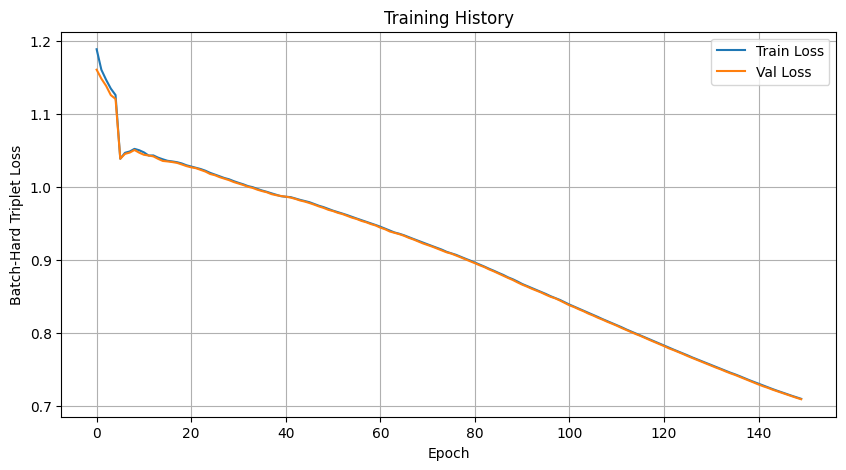

Training history plotted.


In [62]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Train Loss')
if history['val_loss']:
    plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Batch-Hard Triplet Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'))
plt.show()

print("Training history plotted.")

In [63]:
# Load best model
embedding_model = tf.keras.models.load_model(
    MODEL_PATH,
    compile=False,
    safe_mode=False
)
print(f"Best model loaded from {MODEL_PATH}")

Best model loaded from /kaggle/working/siamese_base_network.keras


In [64]:
# Calibration with guards: fit logistic regression on validation similarities
print("Computing calibration on validation set...")

val_pairs_same = []
val_pairs_diff = []

labeled_classes = [c for c in ALL_CLASSES if c != 'Background']

for class_name in labeled_classes:
    chips = val_examples.get(class_name, [])
    if len(chips) < 2:
        continue
    
    embeddings = embedding_model.predict(np.array(chips), batch_size=32, verbose=0)
    for i in range(len(embeddings)):
        for j in range(i+1, len(embeddings)):
            sim = np.dot(embeddings[i], embeddings[j])
            val_pairs_same.append(sim)
    
    other_classes = [c for c in labeled_classes if c != class_name and len(val_examples.get(c, [])) > 0]
    for other_class in other_classes[:3]:
        other_chips = val_examples[other_class][:5]
        if len(other_chips) == 0:
            continue
        other_embeddings = embedding_model.predict(np.array(other_chips), batch_size=32, verbose=0)
        for emb1 in embeddings[:5]:
            for emb2 in other_embeddings:
                sim = np.dot(emb1, emb2)
                val_pairs_diff.append(sim)

print(f"  Same-class pairs: {len(val_pairs_same)}")
print(f"  Diff-class pairs: {len(val_pairs_diff)}")

MIN_PAIRS = 20
if len(val_pairs_same) < MIN_PAIRS or len(val_pairs_diff) < MIN_PAIRS:
    print(f"\n  Insufficient validation pairs for calibration (need >= {MIN_PAIRS} each)")
    print("  Using fallback: identity calibration (no transformation)")
    
    class IdentityCalibrator:
        def predict_proba(self, X):
            probs = (X + 1) / 2.0
            return np.column_stack([1 - probs, probs])
    
    calibrator = IdentityCalibrator()
    
    with open(CALIBRATION_PATH, 'wb') as f:
        pickle.dump(calibrator, f)
    
    print(f"Fallback calibration saved to {CALIBRATION_PATH}")
    
    threshold_global = 0.3  # LOWERED from 0.5 to allow cosine sim >= -0.4
else:
    X_cal = np.array(val_pairs_same + val_pairs_diff).reshape(-1, 1)
    y_cal = np.array([1] * len(val_pairs_same) + [0] * len(val_pairs_diff))
    
    calibrator = LogisticRegression()
    calibrator.fit(X_cal, y_cal)
    
    with open(CALIBRATION_PATH, 'wb') as f:
        pickle.dump(calibrator, f)
    
    print(f"Calibration model saved to {CALIBRATION_PATH}")
    
    threshold_global = 0.3  # LOWERED from 0.5

class_thresholds = {c: threshold_global for c in ALL_CLASSES}

with open(THRESHOLDS_PATH, 'w') as f:
    json.dump(class_thresholds, f, indent=2)

print(f"Class thresholds saved to {THRESHOLDS_PATH}")

# Diagnostic: Show calibrator behavior
print(f"\n Calibrator Diagnostics:")
print(f"  Calibrator type: {type(calibrator).__name__}")
print(f"  Global threshold: {threshold_global}")
print(f"  Cosine similarity → Probability mapping:")
print(f"    cos_sim = -1.0 → prob = {calibrator.predict_proba([[-1.0]])[0,1]:.3f}")
print(f"    cos_sim =  0.0 → prob = {calibrator.predict_proba([[0.0]])[0,1]:.3f}")
print(f"    cos_sim = +0.5 → prob = {calibrator.predict_proba([[0.5]])[0,1]:.3f}")
print(f"    cos_sim = +1.0 → prob = {calibrator.predict_proba([[1.0]])[0,1]:.3f}")
print(f"  Threshold {threshold_global} requires cos_sim >= {threshold_global*2 - 1:.2f}")

Computing calibration on validation set...
  Same-class pairs: 29
  Diff-class pairs: 184
Calibration model saved to /kaggle/working/calibration_params.pkl
Class thresholds saved to /kaggle/working/class_thresholds.json

 Calibrator Diagnostics:
  Calibrator type: LogisticRegression
  Global threshold: 0.3
  Cosine similarity → Probability mapping:
    cos_sim = -1.0 → prob = 0.002
    cos_sim =  0.0 → prob = 0.064
    cos_sim = +0.5 → prob = 0.290
    cos_sim = +1.0 → prob = 0.710
  Threshold 0.3 requires cos_sim >= -0.40


In [65]:
# Inference functions with prototypes and calibration
def build_class_prototype(class_name, exemplar_chips, model):
    """Build prototype embedding from multiple exemplars."""
    embeddings = model.predict(np.array(exemplar_chips), batch_size=32, verbose=0)
    embeddings = embeddings.astype(np.float32)
    prototype = np.mean(embeddings, axis=0)
    prototype = prototype / np.linalg.norm(prototype)
    return prototype.astype(np.float32)

def search_image_efficient(prototype_embedding, target_image, model, stats, 
                           stride, chip_size, calibrator, threshold):
    """Efficient sliding-window search with calibrated scoring."""
    h, w, _ = target_image.shape
    
    # Normalize target image
    target_image = normalize_image(target_image, stats)
    
    all_patches = []
    all_coords = []
    
    for y in range(0, h - chip_size[0] + 1, stride):
        for x in range(0, w - chip_size[1] + 1, stride):
            patch = target_image[y:y+chip_size[0], x:x+chip_size[1]]
            all_patches.append(patch)
            all_coords.append((x, y))
    
    if not all_patches:
        return []
    
    # Batch predict
    all_patches = np.array(all_patches, dtype=np.float32)
    all_embeddings = model.predict(all_patches, batch_size=64, verbose=0).astype(np.float32)
    proto = prototype_embedding.astype(np.float32)
    
    # Compute cosine similarities
    similarities = np.dot(all_embeddings, proto)
    
    # Calibrate to probabilities
    probs = calibrator.predict_proba(similarities.reshape(-1, 1))[:, 1]
    
    # Threshold
    matching_indices = np.where(probs >= threshold)[0]
    
    detections = []
    for idx in matching_indices:
        x, y = all_coords[idx]
        score = float(probs[idx])
        detections.append({
            'box': [x, y, x + chip_size[1], y + chip_size[0]],
            'score': score
        })
    
    return detections

print("Inference functions with prototypes and calibration defined.")

Inference functions with prototypes and calibration defined.


In [66]:
# Generate submission for MOCK dataset (testing_set)
print("Generating submission for MOCK dataset...")

with open(CALIBRATION_PATH, 'rb') as f:
    calibrator = pickle.load(f)

with open(THRESHOLDS_PATH, 'r') as f:
    class_thresholds = json.load(f)

all_results = []
inference_classes = [c for c in ALL_CLASSES if c != 'Background']

mock_files = [f for f in os.listdir(MOCK_DATASET_DIR) if f.endswith('.tif')]
print(f"MOCK images found: {len(mock_files)}")

if len(mock_files) == 0:
    print("  ERROR: No mock images found! Check MOCK_DATASET_DIR path.")
else:
    for class_name in inference_classes:
        exemplar_pool = train_examples.get(class_name, [])
        ex_n = min(NUM_EXEMPLARS, len(exemplar_pool))
        exemplar_chips = exemplar_pool[:ex_n]
        
        if len(exemplar_chips) == 0:
            print(f" No exemplars for '{class_name}', skipping.")
            continue
        
        print(f"\n--- Searching for '{class_name}' (using {len(exemplar_chips)} exemplars) ---")
        
        prototype = build_class_prototype(class_name, exemplar_chips, embedding_model)
        threshold = class_thresholds[class_name]
        
        class_detections = []
        class_max_prob = 0.0
        class_raw_sims = []
        
        for filename in tqdm(mock_files, desc=f"Scanning {class_name}"):
            image_path = os.path.join(MOCK_DATASET_DIR, filename)
            target_image = load_4_band_image_raw(image_path)
            
            detections = search_image_efficient(
                prototype, target_image, embedding_model, norm_stats,
                STRIDE_COARSE, CHIP_SIZE, calibrator, threshold
            )
            
            for det in detections:
                det['filename'] = filename
                det['class_name'] = class_name
                class_raw_sims.append(det['score'])
            
            if detections:
                class_max_prob = max(class_max_prob, max(d['score'] for d in detections))
            
            class_detections.extend(detections)
        
        print(f"  Max probability: {class_max_prob:.4f}, Raw detections: {len(class_detections)}")
        
        if len(class_raw_sims) > 0:
            print(f"  Score range: [{min(class_raw_sims):.3f}, {max(class_raw_sims):.3f}], Mean: {np.mean(class_raw_sims):.3f}")
        
        if not class_detections:
            print(f"   No detections for '{class_name}'")
            continue
        
        boxes = np.array([d['box'] for d in class_detections], dtype=np.float32)
        scores = np.array([d['score'] for d in class_detections], dtype=np.float32)
        
        selected_indices = tf.image.non_max_suppression(
            boxes, scores, max_output_size=500, iou_threshold=NMS_THRESHOLD
        ).numpy()
        
        print(f"  Detections after NMS: {len(selected_indices)}")
        
        for idx in selected_indices:
            det = class_detections[idx]
            all_results.append({
                'x_min': int(det['box'][0]),
                'y_min': int(det['box'][1]),
                'x_max': int(det['box'][2]),
                'y_max': int(det['box'][3]),
                'class_name': det['class_name'],
                'filename': det['filename'],
                'score': det['score']
            })

print(f"\nTotal detections across all classes: {len(all_results)}")

Generating submission for MOCK dataset...
MOCK images found: 40

--- Searching for 'Playground' (using 5 exemplars) ---


Scanning Playground:   0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/l

  Max probability: 0.4420, Raw detections: 407
  Score range: [0.300, 0.442], Mean: 0.323
  Detections after NMS: 333

--- Searching for 'Brick Kiln' (using 5 exemplars) ---


Scanning Brick Kiln:   0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/l

  Max probability: 0.6609, Raw detections: 1168
  Score range: [0.300, 0.661], Mean: 0.439
  Detections after NMS: 500

--- Searching for 'Metro Shed' (using 4 exemplars) ---


Scanning Metro Shed:   0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/l

  Max probability: 0.6051, Raw detections: 101
  Score range: [0.300, 0.605], Mean: 0.327
  Detections after NMS: 86

--- Searching for 'Pond-1' (using 5 exemplars) ---


Scanning Pond-1:   0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/l

  Max probability: 0.6939, Raw detections: 46414
  Score range: [0.300, 0.694], Mean: 0.495
  Detections after NMS: 500

--- Searching for 'Pond-2' (using 5 exemplars) ---


Scanning Pond-2:   0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/l

  Max probability: 0.5545, Raw detections: 1145
  Score range: [0.300, 0.555], Mean: 0.355
  Detections after NMS: 500

--- Searching for 'Sheds' (using 5 exemplars) ---


Scanning Sheds:   0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/l

  Max probability: 0.6158, Raw detections: 21903
  Score range: [0.300, 0.616], Mean: 0.388
  Detections after NMS: 500

--- Searching for 'Solar Panel' (using 5 exemplars) ---


Scanning Solar Panel:   0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/l

  Max probability: 0.5970, Raw detections: 478
  Score range: [0.300, 0.597], Mean: 0.359
  Detections after NMS: 366

--- Searching for 'STP' (using 5 exemplars) ---


Scanning STP:   0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/l

  Max probability: 0.5723, Raw detections: 552
  Score range: [0.300, 0.572], Mean: 0.360
  Detections after NMS: 371

Total detections across all classes: 3156


In [67]:
# Write submission CSV in required format (no header)
# Fields: x_min,y_min,x_max,y_max,searched_object_name,target_imagery_file_name,similarity_score

submission_path = os.path.join(OUTPUT_DIR, 'submission.csv')

# Sort by score descending for better presentation
all_results_sorted = sorted(all_results, key=lambda x: x['score'], reverse=True)

with open(submission_path, 'w') as f:
    for r in all_results_sorted:
        line = f"{r['x_min']},{r['y_min']},{r['x_max']},{r['y_max']},{r['class_name']},{r['filename']},{r['score']:.4f}\n"
        f.write(line)

print(f"Submission CSV written to: {submission_path}")
print(f"Total rows: {len(all_results_sorted)}")

# Preview first 5 lines
with open(submission_path, 'r') as f:
    for i, line in enumerate(f):
        if i >= 5:
            break
        print(f"  {line.strip()}")

Submission CSV written to: /kaggle/working/submission.csv
Total rows: 3156
  1024,32,1088,96,Pond-1,GC01PS03T0029.tif,0.6939
  672,896,736,960,Pond-1,GC01PS03T0027.tif,0.6935
  96,704,160,768,Pond-1,GC01PS03T0027.tif,0.6923
  160,672,224,736,Pond-1,GC01PS03T0237.tif,0.6921
  1952,1408,2016,1472,Pond-1,GC01PS03T0237.tif,0.6908
